In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('../Kaggle_dataset/ACWI3.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,48.919998,49.070000,48.709999,49.040001,41.957142,2298300
1,1/3/2013,48.810001,49.080002,48.720001,48.830002,41.777470,1567500
2,1/4/2013,48.840000,49.099998,48.750000,49.040001,41.957142,1400200
3,1/7/2013,48.790001,48.889999,48.669998,48.840000,41.786026,1497400
4,1/8/2013,48.709999,48.750000,48.430000,48.599998,41.580692,306300


In [3]:
short_window = int(0.025 * len(df))
long_window = int(0.05 * len(df))

signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

signals['short_ma'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_ma'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] 
                                            > signals['long_ma'][short_window:], 1.0, 0.0)   
signals['positions'] = signals['signal'].diff()

signals

,signal,short_ma,long_ma,positions
0,0.0,49.040001,49.040001,NaN
1,0.0,48.935001,48.935001,0.0
2,0.0,48.970001,48.970001,0.0
3,0.0,48.937501,48.937501,0.0
4,0.0,48.870000,48.870000,0.0
...,...,...,...,...
1757,1.0,77.281591,75.280796,0.0
1758,1.0,77.383182,75.365455,0.0
1759,1.0,77.482046,75.451932,0.0
1760,1.0,77.565228,75.550000,0.0


In [4]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [5]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['positions'])

day 44: buy 1 units at price 50.730000, total balance 9949.270000
day 141, sell 1 units at price 52.750000, investment 3.981866 %, total balance 10002.020000,
day 168: buy 1 units at price 51.599998, total balance 9950.420002
day 430, sell 1 units at price 60.250000, investment 16.763569 %, total balance 10010.670002,
day 498: buy 1 units at price 59.200001, total balance 9951.470001
day 525, sell 1 units at price 59.389999, investment 0.320944 %, total balance 10010.860001,
day 550: buy 1 units at price 58.810001, total balance 9952.049999
day 637, sell 1 units at price 60.389999, investment 2.686614 %, total balance 10012.439999,
day 731: buy 1 units at price 58.009998, total balance 9954.430000
day 762, sell 1 units at price 52.580002, investment -9.360449 %, total balance 10007.010002,
day 824: buy 1 units at price 56.230000, total balance 9950.780003
day 971, sell 1 units at price 58.220001, investment 3.539039 %, total balance 10009.000004,
day 1003: buy 1 units at price 59.36000

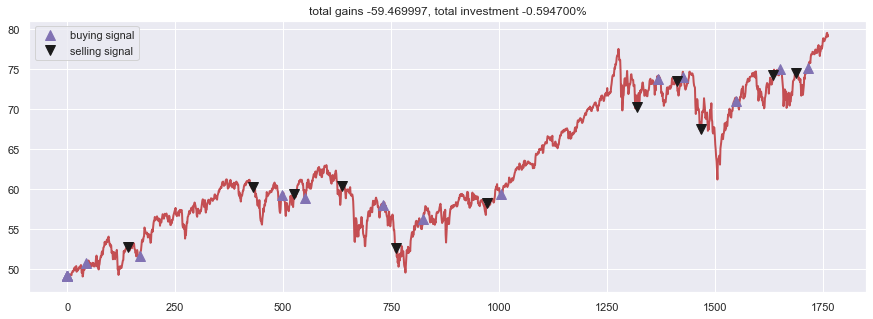

In [6]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()